In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torch.utils.data import DataLoader, Dataset
from glob import glob
from itertools import chain
import random

class EuroSATDataset(Dataset):
    
    def __init__(self, root, train_flag = True):
        
        self.train_flag = train_flag
        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")]
        self.images_paths = list(chain.from_iterable(self.images_paths))
        random.shuffle(self.images_paths)
    
        # комментарий преподавателя: на текущей машине очень мало мощностей, максимально обрезаем данные
        # для обучения и валидации в соотношении 100/30
        
        self.count = {True: 100}
        self.count[False] = 30
        

        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]
        
        # применяем аугментациб данных. В качестве ДЗ расширите список применяемых преобразований.
        self.transform_train = transforms.Compose([
            transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225]),
            torchvision.transforms.RandomResizedCrop((224,224))
                                                  ])
        self.transform_test =  transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
                          
    
    def __len__(self):
        return self.count[self.train_flag]
        
    def __getitem__(self, index):
        if (self.train_flag):
            index = index % self.count[True]
        else:
            index = self.count[True] + index % self.count[False]
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (224,224))
        image = torch.tensor(image/255).permute(2,0,1)
        if self.train_flag: 
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        label = self.labels[index]
        
        return image.float().to(device), torch.tensor([label]).float().to(device)

In [4]:
data =  EuroSATDataset('./EuroSAT_small/2750', train_flag=True)
len(data)

100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Size: 224 x 224 x 3
Label: tensor([9.])
SeaLake


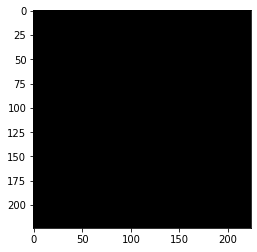

In [5]:
import random
import cv2

image, label = data[random.randint(0, len(data))]
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()

In [24]:
train_dataset = EuroSATDataset('./EuroSAT_small/2750')
test_dataset = EuroSATDataset('./EuroSAT_small/2750',train_flag = False)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

In [25]:
# fine turning MODEL
# change last model layer (model.fc) for classification on EuroSAT set of classes, 10 classes 
# (not 1000 like for ImageNet dataset pretrained weights)
# pretrained models https://pytorch.org/vision/stable/models.html

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features,10)
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [32]:
# Specify number of epochs and learning rate
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [33]:
def train_step(model, loss_function, optimizer, image, label):
    model.train()
    optimizer.zero_grad()
    prediction = model(image)
    #print(prediction)
    #print(label)
    loss = loss_function(prediction.squeeze(), label.long().squeeze())
    loss.backward()
    optimizer.step()
    return loss.item()

In [34]:
@torch.no_grad()
def accuracy(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == label.int().squeeze()
    return is_correct.cpu().numpy().tolist()

In [35]:
@torch.no_grad()
def validation_loss(model, loss_function, image, label):
    model.eval()
    prediction = model(image)
    loss = loss_function(prediction.squeeze(), label.long().squeeze())
    return loss.item()

In [36]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

n_epochs = 10
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_epoch_losses = []
    train_epoch_accuracies = []
    for idx,(image, label) in enumerate(train_dataset_loader):
        loss = train_step(model, criterion, optimizer, image, label)
        train_epoch_losses.append(loss)
        print(loss)
        #if (idx + 1) %100 == 0: print(loss)
    train_epoch_loss = np.mean(train_epoch_losses)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    train_losses.append(train_epoch_loss)
    
    for idx,(image, label) in enumerate(train_dataset_loader):
        is_correct = accuracy(model, criterion, image, label)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy: {train_epoch_accuracy*100:.2f}%")
    train_accuracies.append(train_epoch_accuracy)
    
    test_epoch_losses = []
    test_epoch_accuracies = []
    for idx,(image, label) in enumerate(test_dataset_loader):
        #print(label)
        loss = validation_loss(model, criterion, image, label)
        test_epoch_losses.append(loss)
        is_correct = accuracy(model, criterion, image, label)
        test_epoch_accuracies.extend(is_correct)
    test_epoch_loss = np.mean(test_epoch_losses)
    print(f"Test Loss: {test_epoch_loss:.4f}")
    test_losses.append(test_epoch_loss)
    test_epcoh_accuracy = np.mean(test_epoch_accuracies)
    print(f"Test Accuracy: {test_epcoh_accuracy*100:.2f}%")
    test_accuracies.append(test_epcoh_accuracy)

Epoch: 1
2.577773332595825
2.4569621086120605
2.4273147583007812
Train Loss: 2.4874
Train Accuracy: 15.62%
Test Loss: 2.0134
Test Accuracy: 16.67%
Epoch: 2
2.14536714553833
2.0890893936157227
1.8905028104782104
Train Loss: 2.0417
Train Accuracy: 22.92%
Test Loss: 1.8813
Test Accuracy: 13.33%
Epoch: 3
1.833150863647461
1.7798854112625122
1.5818525552749634
Train Loss: 1.7316
Train Accuracy: 41.67%
Test Loss: 1.6648
Test Accuracy: 43.33%
Epoch: 4
1.5987660884857178
1.446637749671936
1.49248468875885
Train Loss: 1.5126
Train Accuracy: 64.58%
Test Loss: 1.4510
Test Accuracy: 60.00%
Epoch: 5
1.3754477500915527
1.3106598854064941
1.3965295553207397
Train Loss: 1.3609
Train Accuracy: 72.92%
Test Loss: 1.2781
Test Accuracy: 70.00%
Epoch: 6
1.2375372648239136
1.132124900817871
1.1684354543685913
Train Loss: 1.1794
Train Accuracy: 75.00%
Test Loss: 1.1738
Test Accuracy: 83.33%
Epoch: 7
1.1900911331176758
0.9683022499084473
0.9833035469055176
Train Loss: 1.0472
Train Accuracy: 78.12%
Test Loss: 1

In [ ]:
# example of model saving
model_dir = "./models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file
torch.save(model.state_dict(), model_file)

In [ ]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth.


In [ ]:
# EXAMPLE OF MODEL LOADING
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features,10)
model = model.to(device)

In [ ]:
# example of loading model from the file
model.load_state_dict(torch.load(PATH, weights_only=True))

Model file ./drive/My Drive/Colab Notebooks/models/best_model.pth successfully loaded.


In [ ]:
# 1. Выберите иную модель из доступных предтренированных моделей: https://pytorch.org/vision/main/models.html
# Загрузите предобученные веса.
# 2. Преобразуйте выходной слой модели для дообучения на текущей задаче классификации.
# 3. Дообучите модель.
# 3.1 Проводите обучение, по возможности, на всем доступном наборе данных. Если вычислительных мощностей достаточно,
# можете использовать полный набор данных EuroSAT (без _small).
# 4. Сохраните модель с лучшими параметрами качества.

# Изучите аугментацию данных https://pytorch.org/vision/main/transforms.html
# Добавьте дополнительную аугментацию данных для шага тренировки.
# Проведите дообучение еще раз. Исследуйте, изменилась ли скорость сходимости сети. Какова точность классификации?